In [53]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
import cv2
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
import numpy as np


In [54]:
class MaxPool(nn.Module):
    def __init__(self, pool_size):
        super(MaxPool, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=pool_size, stride=pool_size)

    def forward(self, x):
        return self.pool(x)


class Noise(nn.Module):
    def __init__(self, R_scale):
        super(Noise, self).__init__()
        self.mean = 0
        self.stdev = 1  # as defined in the paper

    def forward(self, d_coarse):
        noise = torch.rand_like(d_coarse)*self.stdev + self.mean
        d_noised = d_coarse + noise
        return d_noised


class IntervalThreshold(nn.Module):
    def __init__(self, m, n):
        super(IntervalThreshold, self).__init__()
        self.m = m
        self.n = n

    def forward(self, d_pool):
        threshold = (torch.max(d_pool) - torch.min(d_pool))/min(self.m, self.n)
        return threshold


class ReconGraph(nn.Module):
    def __init__(self, m, n):
        super(ReconGraph, self).__init__()
        self.m = m
        self.n = n

    def forward(self, d_noised, threshold):
        neighbours = set()
        labels = {}

        count = 0

        for i in range(self.m):
            for j in range(self.n):

                labels[(j, i)] = count  # Labeling each pixel in (x, y) form
                count += 1
                for dy in range(-1, 2):
                    for dx in range(-1, 2):
                        if dx != 0 and dy != 0 and i+dy >= 0 and i+dy < self.m and j+dx >= 0 and j+dx < self.n:
                            if abs(d_noised[0][0][i+dy][j+dx] - d_noised[0][0][i][j]) <= threshold:
                                # (x, y) format
                                neighbours.add(((j, i), (j+dx, i+dy)))
        adjacency_matrix = torch.zeros(
            (self.m*self.n, self.m*self.n), dtype=bool)
        print(adjacency_matrix.shape)

        for val in neighbours:

            N1, N2 = val  # in (x, y) form
            N1_x, N1_y = N1
            N2_x, N2_y = N2

            l1 = labels[(N1_x, N1_y)]
            l2 = labels[(N2_x, N2_y)]

            # Symmetric connections
            adjacency_matrix[l1, l2] = 1
            adjacency_matrix[l2, l1] = 1

        return adjacency_matrix


class GraphDropout(nn.Module):
    def __init__(self, p=0.5) -> None:
        super(GraphDropout, self).__init__()
        self.p = p

    def forward(self, adjacency_matrix):
        if self.train:
            mask = torch.empty_like(adjacency_matrix).bernoulli_(1 - self.p)
            output = adjacency_matrix * mask

        else:
            output = adjacency_matrix

        return output


class ExtractGraph(nn.Module):

    def __init__(self, d_coarse, R_scale, m, n) -> None:
        super(ExtractGraph, self).__init__()
        self.d_coarse = d_coarse
        self.R_scale = R_scale

        self.maxpool = MaxPool(pool_size=2)
        self.noise = Noise(R_scale=0.4)  # From paper results
        self.interval_threshold = IntervalThreshold(m, n)
        self.recon_graph = ReconGraph(m, n)
        self.dropout = GraphDropout(p=0.5)

    def forward(self):
        d_pool = self.maxpool.forward(self.d_coarse)
        print("pooled shape ", d_pool.shape)
        d_noise = self.noise.forward(d_pool)
        threshold = self.interval_threshold.forward(d_pool)
        adjacency_matrix = self.recon_graph.forward(d_noise, threshold)
        adjacency_matrix = self.dropout.forward(adjacency_matrix)

        return adjacency_matrix


In [55]:
class Encoder(nn.Module):

    def __init__(self) -> None:
        super(Encoder, self).__init__()
        encoder = models.resnet.resnet50(
            weights=models.ResNet50_Weights.DEFAULT)
        encoder = nn.Sequential(*list(encoder.children()))[:4]
        self.resnet_encoder = encoder

    def forward(self, x):
        self.resnet_encoder.eval()
        return self.resnet_encoder(x)


In [56]:
class GNNModel(nn.Module):

    def __init__(self, n_features) -> None:
        super(GNNModel, self).__init__()
        self.gcn1 = pyg_nn.GCNConv(n_features, 128)
        self.gcn2 = pyg_nn.GCNConv(128, 256)
        self.gcn3 = pyg_nn.GCNConv(256, 32)
        self.gcn4 = pyg_nn.GCNConv(32, 1)

    def forward(self, x, edge_index):
        x = F.relu(self.gcn1(x, edge_index))
        x = F.relu(self.gcn2(x, edge_index))
        x = F.relu(self.gcn3(x, edge_index))
        x = F.relu(self.gcn4(x, edge_index))

        return x


In [57]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [58]:
from torchvision.transforms import transforms
from PIL import Image

preprocessing_transform = transforms.Compose([
    transforms.Resize((320, 240), interpolation=Image.Resampling.BILINEAR),
    transforms.CenterCrop((304, 228)),
    transforms.ToTensor()
])

/Users/adityadandwate/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [59]:
from gcn_depth_dataloader import GCNDepthDataLoader
from torch.utils.data import DataLoader

# for train set
nyu_dataset_train = GCNDepthDataLoader(mode='train', 
                                image_folder='../dataset/dataset/nyu_depth_v2/official_splits/train/rgb',
                                depth_folder='../dataset/dataset/nyu_depth_v2/official_splits/train/depth',
                                transform=preprocessing_transform)

nyu_dataset_train.__len__()

train_dataloader = DataLoader(nyu_dataset_train, batch_size=8, shuffle=True)

torch.Size([8, 3, 304, 228]) torch.Size([8, 1, 304, 228])
grid shape rgb  torch.Size([3, 308, 1842])
(308, 1842, 3)


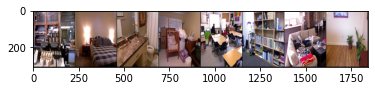

In [69]:
from torchvision.utils import make_grid

batch = next(iter(train_dataloader))
rgb, depth = batch

print(rgb.shape, depth.shape)

rgb_grid = make_grid(rgb)
print('grid shape rgb ', rgb_grid.shape)
rgb_grid = rgb_grid.numpy().transpose((1, 2, 0))  
print(rgb_grid.shape)  
plt.imshow(rgb_grid)
plt.show()



In [61]:
def loss_fn(pred_adj_matrix, grnd_adj_matrix, pred_depth, grnd_depth, dice_coefficient):

    grad_x = torch.gradient(pred_depth, dim=1)
    grad_y = torch.gradient(pred_depth, dim=0)

    squared_mag = torch.square(grad_x) + torch.square(grad_y)
    avg_squared_mag = torch.mean(squared_mag)

    l_grad = avg_squared_mag  

    ############

    smooth = 1e-7   # To avoid division by zero
    intersection = torch.sum(pred_adj_matrix, grnd_adj_matrix)
    union = torch.sum(pred_adj_matrix) + torch.sum(grnd_adj_matrix)

    dice_score = (2.0*intersection + smooth)/(union + smooth)
    l_dice = 1.0 - dice_score

    ###########

    l_si = 0

    final_loss = l_grad + dice_coefficient*l_dice + l_si
    return final_loss



In [62]:
encoder = Encoder()
    
midas_model_type = "MiDaS_small"
midas = torch.hub.load("intel-isl/MiDaS", midas_model_type)
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if midas_model_type == "DPT_Large" or midas_model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform



Using cache found in /Users/adityadandwate/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /Users/adityadandwate/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /Users/adityadandwate/.cache/torch/hub/intel-isl_MiDaS_master


(1280, 1920, 3)
input batch shape  torch.Size([1, 3, 160, 256])
shape through midas  torch.Size([1, 160, 256])


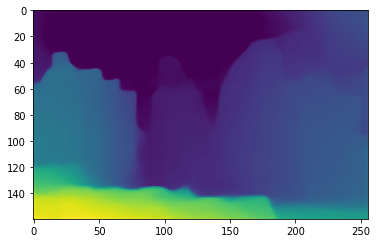

In [77]:
img = cv2.imread("../test_images/inputs/skyscraper_city.jpeg")
print(img.shape)
input_batch = transform(img).to(device)
print('input batch shape ', input_batch.shape)

with torch.no_grad():
        prediction = midas(input_batch)

        # prediction = F.interpolate(
        #     prediction.unsqueeze(1),
        #     mode="bicubic",
        #     align_corners=False
        # ).squeeze()

depth_map = prediction.cpu()
print("shape through midas ", depth_map.shape)
plt.imshow(depth_map.numpy().squeeze())

In [83]:
def transform_batch(in_batch):

    transformed_images = []

    for img in in_batch:

        img = img.permute(1, 2, 0)  #tensor shape (H, W, C)
        np_image = np.array(img.numpy())
        transformed_image = transform(np_image).to(device)
        transformed_images.append(transformed_image)
    
    transformed_batch = torch.stack(transformed_images)
    return transformed_batch

In [87]:
# print(batch.shape)
batch = next(iter(train_dataloader))
rgb, depth = batch
# print(rgb.shape)
transformed_batch = transform_batch(rgb)
transformed_batch = transformed_batch.squeeze()
print(transformed_batch.shape)

torch.Size([8, 3, 256, 192])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 192])


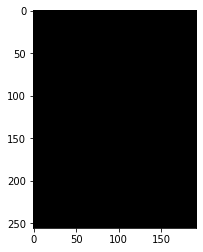

In [96]:
for img in transformed_batch:
    print(img.shape)
    img = img.permute(1, 2, 0)
    plt.imshow(img)
    break

In [88]:
midas_output_batch = midas(transformed_batch)

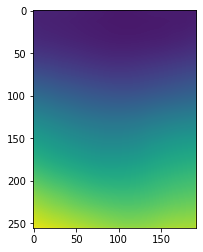

In [91]:
for depth_img in midas_output_batch:
    depth_map = depth_img.cpu()
    plt.imshow(depth_map.detach().numpy().squeeze())
    break
